In [ ]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

'''import kagglehub
borismarjanovic_price_volume_data_for_all_us_stocks_etfs_path = kagglehub.dataset_download('borismarjanovic/price-volume-data-for-all-us-stocks-etfs')
print('Data source import complete.')'''

### Read historical prices

I read historical data frame for a chosen stock (e.g. CERN) which I am going to analyze. New York Stock Exchange dataset provides day by day price history gathered over more than 10 years. I decided to crop the time frame and start it from a year 2010 to reduce amount of data to be processed.

Removing rows is then followed by reindexing the data frame to keep it clean.

### Introduction

In this kernel I use XGBRegressor from XGBoost library to predict future prices of stocks using technical indicator as features. If you are looking for an explanation of indicators (e.g. moving averages, RSI, MACD) used below, please refer to [articles on Investopedia](https://www.investopedia.com/technical-analysis-4689657) or [this notebook of mine](https://www.kaggle.com/mtszkw/analysis-and-technical-indicators-for-trading-etfs) where I introduce and visualize various technical analysis concepts.

In [25]:
import os
import numpy as np
import pandas as pd
import xgboost as xgb
import matplotlib.pyplot as plt
from xgboost import plot_importance, plot_tree
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV

import yfinance as yf
import seaborn as sns
from ta.momentum import RSIIndicator
from ta.trend import MACD
from ta.volatility import BollingerBands
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    classification_report, accuracy_score, confusion_matrix,
    precision_score, recall_score, f1_score,
    precision_recall_curve, average_precision_score,
    roc_curve, roc_auc_score
)

import FinanceDataReader as fdr
from datetime import datetime
from alpha_code_1 import get_alpha

# Chart drawing
import plotly as py
import plotly.io as pio
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

# Mute sklearn warnings
from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)
simplefilter(action='ignore', category=DeprecationWarning)

# Show charts when running kernel
init_notebook_mode(connected=True)

# Change default background color for all visualizations
layout=go.Layout(paper_bgcolor='rgba(0,0,0,0)', plot_bgcolor='rgba(250,250,250,0.8)')
fig = go.Figure(layout=layout)
templated_fig = pio.to_templated(fig)
pio.templates['my_template'] = templated_fig.layout.template
pio.templates.default = 'my_template'

In [26]:
start_date = '2011-01-01'
end_date = '2015-12-31'

df = fdr.DataReader('KS11', start_date, end_date)
df = df.reset_index()

df = df.rename(columns={
    "Open": "S_DQ_OPEN", 
    "High": "S_DQ_HIGH", 
    "Low": "S_DQ_LOW", 
    "Change":"S_DQ_PCTCHANGE",
    "Close": "S_DQ_CLOSE", 
    "Volume": "S_DQ_VOLUME", 
    "Amount":"S_DQ_AMOUNT"
})

df['Date'] = pd.to_datetime(df['Date'])
df.index = range(len(df))
df = get_alpha(df)

In [27]:
# 1. 결측값 채우기 (forward fill → backward fill → 0 대체)
def fill_missing(df):
    df = df.replace([np.inf, -np.inf], 0)
    df = df.fillna(method='ffill')
    df = df.fillna(method='bfill')
    df = df.fillna(0)
    return df

# 결측값 채우기
df = fill_missing(df)
print("결측값 채우기 완료") 

# S_DQ_ 로 시작하는 원본 칼럼들은 제외하고 알파만 선택
alpha_cols = [col for col in df.columns if col.startswith('alpha')]
df_alphas = df[alpha_cols]

# 1. 상관 높은 feature 제거 함수
def remove_highly_correlated_features(df, correlation_threshold=0.99):
    corr_matrix = df.corr().abs()  # 절댓값 상관계수 계산
    upper_triangle = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

    to_drop = [column for column in upper_triangle.columns if any(upper_triangle[column] > correlation_threshold)]
    
    df_cleaned = df.drop(columns=to_drop)
    
    return df_cleaned, to_drop

# 1. 상관 높은 feature 제거
df_alphas, dropped_corr_features = remove_highly_correlated_features(df_alphas, correlation_threshold=0.99)

print(f"상관 관계로 제거한 feature 수: {len(dropped_corr_features)}")

결측값 채우기 완료
상관 관계로 제거한 feature 수: 1


In [ ]:
df_alphas['target'] = df['UpDown'].shift(-1)
df_alphas['target'] = df_alphas['target'].replace(3, 2)
df_alphas['target'] = df_alphas['target'].replace(1, 0)
df_alphas['target'] = df_alphas['target'].replace(2, 1)

df_alphas = df_alphas.dropna()

### Shift label column

Because I want to predict the next day price, after calculating all features for day $D_{i}$, I shift Close price column by -1 rows. After doing that, for day $D_{i}$ we have features from the same timestamp e.g. $RSI_{i}$, but the price $C_{i+1}$ from upcoming day.

In [28]:
df_alphas['Date'] = df['Date']
df_alphas['Close'] = df['S_DQ_CLOSE'].shift(-1)
df_alphas = df_alphas.drop(columns=['alpha084', 'alpha054'])
df = df_alphas.copy()

In [29]:
test_size  = 0.15
valid_size = 0.15

test_split_idx  = int(df.shape[0] * (1-test_size))
valid_split_idx = int(df.shape[0] * (1-(valid_size+test_size)))

train_df  = df.loc[:valid_split_idx].copy()
valid_df  = df.loc[valid_split_idx+1:test_split_idx].copy()
test_df   = df.loc[test_split_idx+1:].copy()

fig = go.Figure()
fig.add_trace(go.Scatter(x=train_df.Date, y=train_df.Close, name='Training'))
fig.add_trace(go.Scatter(x=valid_df.Date, y=valid_df.Close, name='Validation'))
fig.add_trace(go.Scatter(x=test_df.Date,  y=test_df.Close,  name='Test'))
fig.show()

### Split into features and labels

In [30]:
y_train = train_df['Close'].copy()
X_train = train_df.drop(columns=['Close', 'Date'])

y_valid = valid_df['Close'].copy()
X_valid = valid_df.drop(columns=['Close', 'Date'])

y_test  = test_df['Close'].copy()
X_test  = test_df.drop(columns=['Close', 'Date'])

X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 866 entries, 0 to 865
Data columns (total 79 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   alpha001  866 non-null    float64
 1   alpha002  866 non-null    float64
 2   alpha003  866 non-null    float64
 3   alpha004  866 non-null    float64
 4   alpha005  866 non-null    float64
 5   alpha006  866 non-null    float64
 6   alpha007  866 non-null    float64
 7   alpha008  866 non-null    float64
 8   alpha009  866 non-null    float64
 9   alpha010  866 non-null    float64
 10  alpha011  866 non-null    float64
 11  alpha012  866 non-null    float64
 12  alpha013  866 non-null    float64
 13  alpha014  866 non-null    float64
 14  alpha015  866 non-null    float64
 15  alpha016  866 non-null    float64
 16  alpha017  866 non-null    float64
 17  alpha018  866 non-null    float64
 18  alpha019  866 non-null    float64
 19  alpha020  866 non-null    float64
 20  alpha021  866 non-null    float6

### Fine-tune XGBoostRegressor

In [ ]:
'''%%time

parameters = {
    'n_estimators': [100, 200, 300, 400],
    'learning_rate': [0.001, 0.005, 0.01, 0.05],
    'max_depth': [8, 10, 12, 15],
    'gamma': [0.001, 0.005, 0.01, 0.02],
    'random_state': [42]
}

model = xgb.XGBRegressor(objective='reg:squarederror', verbose=False, verbosity=0)
clf = GridSearchCV(model, parameters, scoring='neg_mean_squared_error')

clf.fit(X_train, y_train, eval_set = [(X_valid, y_valid)], verbose=False)

print(f'Best params: {clf.best_params_}')
print(f'Best validation score = {clf.best_score_}')
print(f'Best RMSE: {np.sqrt(-clf.best_score_)}')'''

In [31]:
%%time
from sklearn.model_selection import TimeSeriesSplit

tscv = TimeSeriesSplit(n_splits=5)

parameters = {
    'n_estimators': [100, 200],
    'learning_rate': [0.01, 0.05],
    'max_depth': [8, 10],
    'gamma': [0.001, 0.01],
    'random_state': [42]
}

model = xgb.XGBRegressor(objective='reg:squarederror', verbose=False, verbosity=0)
clf = GridSearchCV(model, parameters, scoring='neg_mean_squared_error', cv=tscv)
clf.fit(X_train, y_train)

print(f'Best params: {clf.best_params_}')
print(f'Best validation score = {clf.best_score_}')
print(f'Best RMSE: {np.sqrt(-clf.best_score_)}')

Best params: {'gamma': 0.001, 'learning_rate': 0.05, 'max_depth': 8, 'n_estimators': 200, 'random_state': 42}
Best validation score = -4595.660026024617
Best RMSE: 67.79129756852731
CPU times: total: 27min 24s
Wall time: 2min 17s


In [32]:
%%time
eval_set = [(X_train, y_train),(X_valid, y_valid)]
model = xgb.XGBRegressor(**clf.best_params_, objective='reg:squarederror')
model.fit(X_train, y_train, eval_set=eval_set, verbose=False)

CPU times: total: 35.4 s
Wall time: 3.45 s


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=0.001, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.05, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=8,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=200,
             n_jobs=None, num_parallel_tree=None, ...)

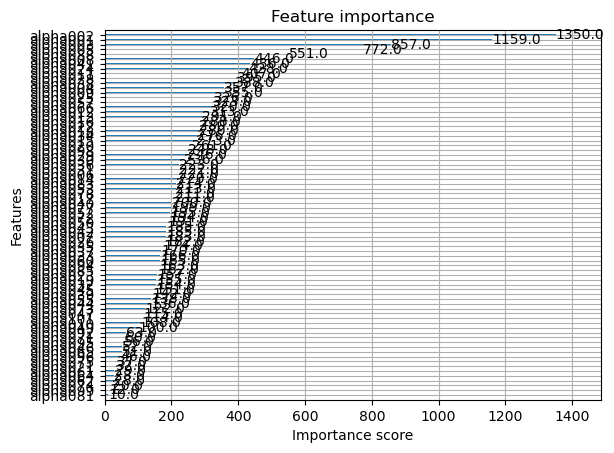

In [33]:
plot_importance(model);

### Calculate and visualize predictions

In [34]:
y_pred = model.predict(X_test)
print(f'y_true = {np.array(y_test)[:5]}')
print(f'y_pred = {y_pred[:5]}')

y_true = [2047.03 2059.26 2058.87 2087.76 2098.92]
y_pred = [2016.538  2009.1223 2012.9398 2030.3738 2014.294 ]


In [38]:
y_test = y_test.replace([np.inf, -np.inf], np.nan).fillna(method='ffill').fillna(method='bfill').fillna(0)

In [39]:
print(f'mean_squared_error = {mean_squared_error(y_test, y_pred)}')

mean_squared_error = 4319.696182267608


In [36]:
predicted_prices = df.loc[test_split_idx+1:].copy()
predicted_prices['Close'] = y_pred

fig = make_subplots(rows=2, cols=1)
fig.add_trace(go.Scatter(x=df.Date, y=df.Close,
                         name='Truth',
                         marker_color='LightSkyBlue'), row=1, col=1)

fig.add_trace(go.Scatter(x=predicted_prices.Date,
                         y=predicted_prices.Close,
                         name='Prediction',
                         marker_color='MediumPurple'), row=1, col=1)

fig.add_trace(go.Scatter(x=predicted_prices.Date,
                         y=y_test,
                         name='Truth',
                         marker_color='LightSkyBlue',
                         showlegend=False), row=2, col=1)

fig.add_trace(go.Scatter(x=predicted_prices.Date,
                         y=y_pred,
                         name='Prediction',
                         marker_color='MediumPurple',
                         showlegend=False), row=2, col=1)

fig.show()